# Financial Econometrics I: Homework 2

Team Member:

Lin Zhang : 15845542@fsv.cuni.cz

Weiwei Qu : 51014941@fsv.cuni.cz

# Problem 1

##### Select 100 random symbols from the symbols.csv file, i.e. using a function in R generate 100 random integers from interval f1,..., 377g, use set.seed('your SIS number') to generate these numbers(e.g. set.seed(26830192)). Then select the Tickers from rows with indices equal to the numbers you generated, and download the prices of stocks denoted by these Tickers for the period 01/2019 - 12/2021. Please restrict the period immediately when downloading the data, it should get downloaded more quickly then.

##### 

* Create data set and verify data validity

In [2]:
# Setup environment
Sys.setenv(LANG = "en")
Sys.setlocale("LC_TIME", "English")
#options(warn = -1)  # suppressing warnings

if (!require(quantmod)) install.packages('quantmod')
if (!require(rugarch)) install.packages('rugarch')

library(quantmod)
library(rugarch)

options(repr.plot.width = 10, repr.plot.height = 8)

[1] "English_United States.1252"

* Select 100 random symbols

In [3]:
# read 377 stock symbols from file
smbs<- as.character(read.csv("symbols2.csv")[,2])

length(smbs)
head(smbs)
tail(smbs)


[1] 377

[1] "MMM"  "ACE"  "ABT"  "ANF"  "ACN"  "ADBE"

[1] "XEL"  "XRX"  "XLNX" "XYL"  "YUM"  "ZION"

In [261]:
set.seed(15845542) # seed for random number generation
s_symbols<-sample(smbs,100) # generate 100 random firms
length(s_symbols)
s_symbols

[1] 100

[1] "CNP"  "TEL"  "PG"   "LLY"  "SO"   "ORLY" "M"    "NRG"  "FSLR" "PFG" 
 [11] "CRM"  "JPM"  "KO"   "OMC"  "AMT"  "GME"  "OKE"  "WHR"  "ITW"  "PRGO"
 [21] "DTE"  "STT"  "CMS"  "AMP"  "SYK"  "TRV"  "LEN"  "NEE"  "AMD"  "NOC" 
 [31] "MSI"  "VFC"  "DVA"  "GPC"  "TAP"  "VMC"  "ALTR" "WEC"  "EBAY" "BBBY"
 [41] "VZ"   "MCHP" "NFX"  "ADM"  "EFX"  "CAT"  "BWA"  "BEN"  "GOOG" "COF" 
 [51] "AFL"  "LOW"  "HRL"  "VLO"  "CCI"  "USB"  "PKI"  "PSX"  "CNX"  "ICE" 
 [61] "T"    "VNO"  "KIM"  "HBAN" "ADP"  "CHRW" "XOM"  "FLS"  "PNW"  "SCHW"
 [71] "NTAP" "MS"   "PCG"  "RHI"  "GNW"  "JNJ"  "MDT"  "ECL"  "WU"   "IP"  
 [81] "SPG"  "MSFT" "CERN" "ALL"  "PFE"  "PBCT" "IRM"  "KMX"  "TROW" "VTR" 
 [91] "MNST" "MA"   "COST" "PM"   "GT"   "FITB" "EW"   "GE"   "BTU"  "MKC"

* Download closing price data

In [262]:
#download data
stock_price <- lapply(s_symbols, function(y)
{
    getSymbols(y, auto.assign = FALSE,from = as.Date('2019-01-01'), to = '2021-12-31')
})
names(stock_price) <- s_symbols


# save data for further usage
#  save(stock_price, file = "1-Price.RData")
# load("1-Price.RData")

Warning message:
"NFX contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them."


* Check the data validity

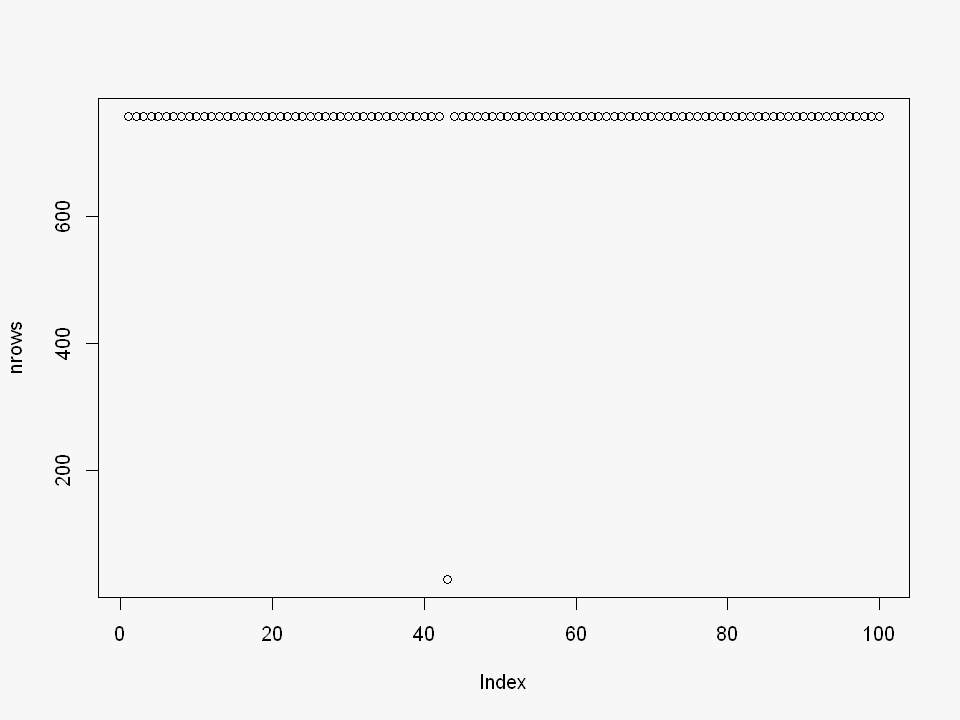

In [330]:
options(repr.plot.width = 8, repr.plot.height = 6)
par(bg = "#f7f7f7")
stock_price1 <- sapply(stock_price,na.omit)
nrows <- unlist(sapply(stock_price1, nrow))
plot(nrows)

In [341]:
length(stock_price1[[1]])
length(stock_price1[[43]])
tail(stock_price1[[43]])

[1] 4536

[1] 180

           NFX.Open NFX.High NFX.Low NFX.Close NFX.Volume NFX.Adjusted
2019-02-06    17.98    18.32  17.830     17.98    4861913        17.98
2019-02-07    17.75    17.86  16.695     16.78    6117067        16.78
2019-02-08    16.64    16.86  16.010     16.30    9083783        16.30
2019-02-11    16.12    16.62  15.890     16.20   13158120        16.20
2019-02-12    16.66    17.20  16.195     16.35   52449682        16.35
2019-02-13    16.58    17.13  16.400     17.07    6651548        17.07

**<span style='background:yellow'>We notied that NFX does not have enough data, need to be removed from our portfolio.</span>**

In [269]:
stock_price$NFX <- NULL
length(stock_price)

s_symbols <- names(stock_price)

* Clean the data set for only Adjusted closing price

In [270]:
# filter for Adjusted price
stock_close <- lapply(s_symbols, function(y){
    stock_price[[y]] <- stock_price[[y]][, paste0(y, '.Adjusted')]
})

# check all symbols used for downloading process are used, no data is missing
length(stock_price)
head(stock_close[[1]])
tail(stock_close[[1]])

[1] 99

           CNP.Adjusted
2019-01-02     25.17500
2019-01-03     25.31885
2019-01-04     25.78639
2019-01-07     25.88529
2019-01-08     26.37981
2019-01-09     26.05612

           CNP.Adjusted
2021-12-22     27.30627
2021-12-23     27.34602
2021-12-27     27.40564
2021-12-28     27.67393
2021-12-29     27.77330
2021-12-30     27.65406

#####  <span style='background: lightblue'>1. Compute the logarithmic returns for the time-series of each stock in your dataset.</span>


In [311]:
# compute log-returns for returns
# multiple 100 to make easier observation

lrets <- lapply(stock_close, function(y){
  y <- na.omit(diff(log(y))) * 100
})
names(lrets) <- s_symbols

head(lrets[[1]])
tail(lrets[[1]])

# Save data for later usage
#  save(lrets, file = "2-Returns.RData")
# load("2-PB.RData")

           CNP.Adjusted
2019-01-03    0.5698056
2019-01-04    1.8297303
2019-01-07    0.3828330
2019-01-08    1.8923747
2019-01-09   -1.2345928
2019-01-10    1.8123148

           CNP.Adjusted
2021-12-22    0.6571838
2021-12-23    0.1454541
2021-12-27    0.2177835
2021-12-28    0.9742092
2021-12-29    0.3584277
2021-12-30   -0.4302647

**Note: We use <span style='background:yellow'>return as percentage number</span>, which already multipled by 100.**

#####  <span style='background: lightblue'>2. For each stocks, estimate the parameters of a GARCH(1, 1) model.</span>

In [303]:
# Set parameters for GARCH(1,1) by ugarchspec()
GarchSet1 <- ugarchspec(mean.model = list(armaOrder = c(0, 0)),
                variance.model = list(garchOrder = c(1, 1)))

# Create matrix stock_coef to store estimate parameters of stocks
N <- length(lrets)  
x <- c(1:N * 4)
rown <- s_symbols
coln <- c("alpha1", "beta1", "alpha1+beta1", "omega")
stock_coef <- matrix(x, nrow = N, ncol = 4, byrow = TRUE, 
            dimnames = list(rown, coln))
l_alpha <- list()
l_beta <- list()
l_omega <- list()

# Run ugarchfit() model to all stocks
for (i in 1 : N){
    GarchFit1 <- ugarchfit(GarchSet1, lrets[[i]])
    l_alpha <- c(l_alpha, GarchFit1@fit$coef['alpha1'])
    l_beta <- c(l_beta, GarchFit1@fit$coef['beta1'])  
    l_omega <- c(l_omega, GarchFit1@fit$coef['omega'])  
}

for (i in 1 : N){
    stock_coef[i,1] <- round(l_alpha[[i]],6)
    stock_coef[i,2] <- round(l_beta[[i]],6)    
    stock_coef[i,4] <- round(l_omega[[i]],6) 
}
stock_coef[,3] <- stock_coef[,1] + stock_coef[,2]

head(stock_coef)
tail(stock_coef)

,alpha1,beta1,alpha1+beta1,omega
CNP,0.176483,0.788045,0.964528,0.149634
TEL,0.105499,0.845579,0.951078,0.157020
PG,0.141440,0.781024,0.922464,0.101469
LLY,0.110536,0.740801,0.851337,0.611329
SO,0.141381,0.815249,0.956630,0.070684
ORLY,0.122371,0.777987,0.900358,0.237718


,alpha1,beta1,alpha1+beta1,omega
GT,0.099793,0.874008,0.973801,0.354003
FITB,0.206394,0.751313,0.957707,0.309252
EW,0.078912,0.843422,0.922334,0.279916
GE,0.104639,0.836236,0.940875,0.460295
BTU,0.091103,0.904973,0.996076,0.528804
MKC,0.155990,0.654959,0.810949,0.392743


#####  <span style='background: lightblue'>3. You will end up with 100 sets of estimated coefficients. Plot the histogram of the 100 $\alpha_1$ coeffcients, and repeat with $\beta_1$ , and $\alpha_1+\beta_1$. </span>

* Plot the histogram of the 100 $\alpha_1$ coeffcients, and repeat with $\beta_1$ , and $\alpha_1+\beta_1$. 

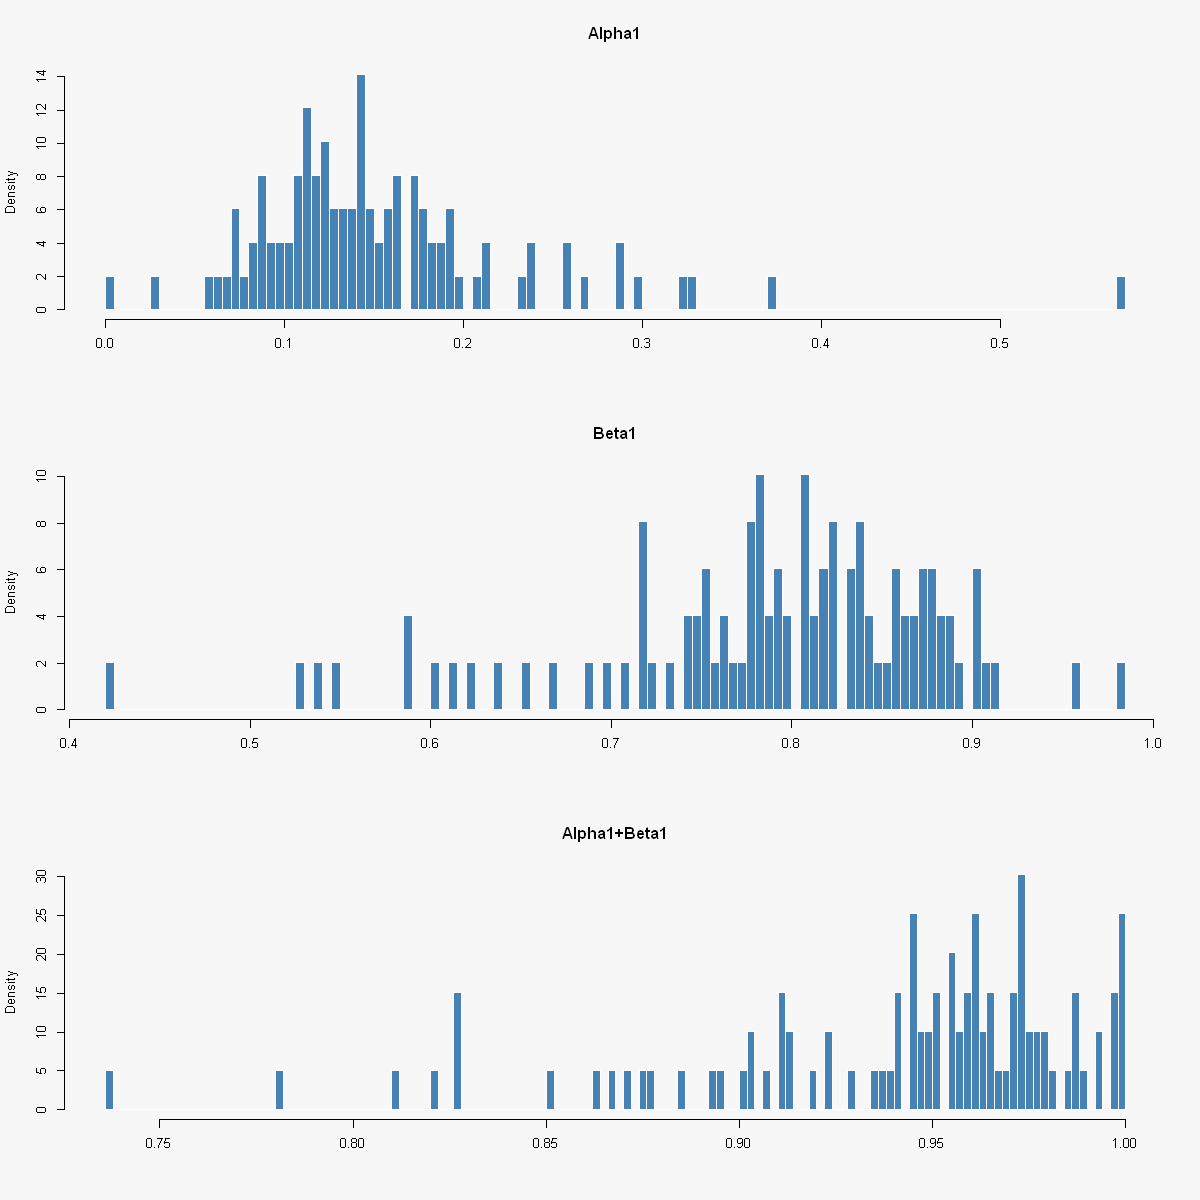

In [339]:
options(repr.plot.width = 10, repr.plot.height = 10)
par(bg = "#f7f7f7")
par(mfrow = c(3, 1))

hist(stock_coef[,"alpha1"], n = 100, probability = TRUE, border = "white",
     col = "steelblue",xlab = NA, main = "Alpha1" )

hist(stock_coef[,"beta1"], n = 100, probability = TRUE, border = "white",
     col = "steelblue", xlab = NA, main = "Beta1" )

hist(stock_coef[,"alpha1+beta1"], n = 100, probability = TRUE, border = "white",
     col = "steelblue", xlab = NA, main = "Alpha1+Beta1" )

**<span style='background: lightblue'>Comment on the cross-sectional variation of the $\alpha_1,\beta_1$,  and $\alpha_1+\beta_1$ and on the consequences that the values of these coeffcients have on the behaviour of the estimated volatility.</span>**

**Comments:  
In a GARCH(1,1) process, we have formula as**  
$$ y_t = \mu_t + a_t  $$
**$a_t$ is for volatility, $\mu_t$ is mean.**

$$ a_t = \sigma_t \epsilon_t \\
\sigma_t^2 = \omega + \alpha_1 a_{t - 1}^2 + \beta_1 \sigma_{t - 1}^2.$$



**We notice that in GRACH(1,1) model, our 100 stocks' $\alpha_1+\beta_1$ are close to 1. When $\beta_1$ is small, the volatility cluster is not obvious. While when $\beta_1$ is greater, because the autocorrelation of $\sigma$ is higher, the volatility spike persistence will longer, there will be a slow decay of volatility, and will show volatility clustering. So from the formula, the volatility equation combines connection with past returns as well as autoregressive dependence.**

#####  <span style='background: lightblue'>4. Find the minimum and maximum values of $\alpha_1,\beta_1$,  and $\alpha_1+\beta_1$.  Comment briefly.</span>

In [304]:
apply(stock_coef, 2, range)

alpha1,beta1,alpha1+beta1,omega
0.004379,0.421428,0.737793,0.034321
0.568214,0.981935,0.999000,7.050201


**First, we find the maximum and minimum parameters in our portfolio.**

In [294]:
max(stock_coef[,"alpha1"])
which.max(stock_coef[,"alpha1"])
min(stock_coef[,"beta1"])
which.min(stock_coef[,"beta1"])

[1] 0.568214

GNW 
 74

[1] 0.421428

GNW 
 74

**Then we locate those individual stocks:  
<span style='background:yellow'>Stock1 GNW</span> has <span style='background:yellow'>Maximum $\alpha_1$</span> at 0.56, as well as minimum $\beta_1$ at 0.42.**

In [295]:
max(stock_coef[,"beta1"])
which.max(stock_coef[,"beta1"])
min(stock_coef[,"alpha1"])
which.min(stock_coef[,"alpha1"])

[1] 0.981935

CHRW 
  65

[1] 0.004379

CHRW 
  65

**<span style='background:yellow'>Stock2 CHRW</span> has Minimum $\alpha_1$ at 0.004, as well as <span style='background:yellow'>Maximum $\beta_1$</span> at 0.98.**

In [299]:
min(stock_coef[,"alpha1+beta1"])
which.min(stock_coef[,"alpha1+beta1"])
max(stock_coef[,"alpha1+beta1"])
which.max(stock_coef[,"alpha1+beta1"])


[1] 0.737793

PRGO 
  20

[1] 0.999

PSX 
 57

**<span style='background:yellow'>Stock3 PRGO</span>  has <span style='background:yellow'>Minimum $\alpha_1+\beta_1$</span> at 0.73, while <span style='background:yellow'>Stock4 PSX</span>  has <span style='background:yellow'>Maximum $\alpha_1+\beta_1$</span> at 0.99.**

In [307]:
# Also check the highest Volatility stock
max(stock_coef[,"omega"])
which.max(stock_coef[,"omega"])

[1] 7.050201

BBBY 
  40

**<span style='background:yellow'>Stock5 BBBY</span>  has <span style='background:yellow'>Highest Volatility $\omega$</span> at 7.05.**

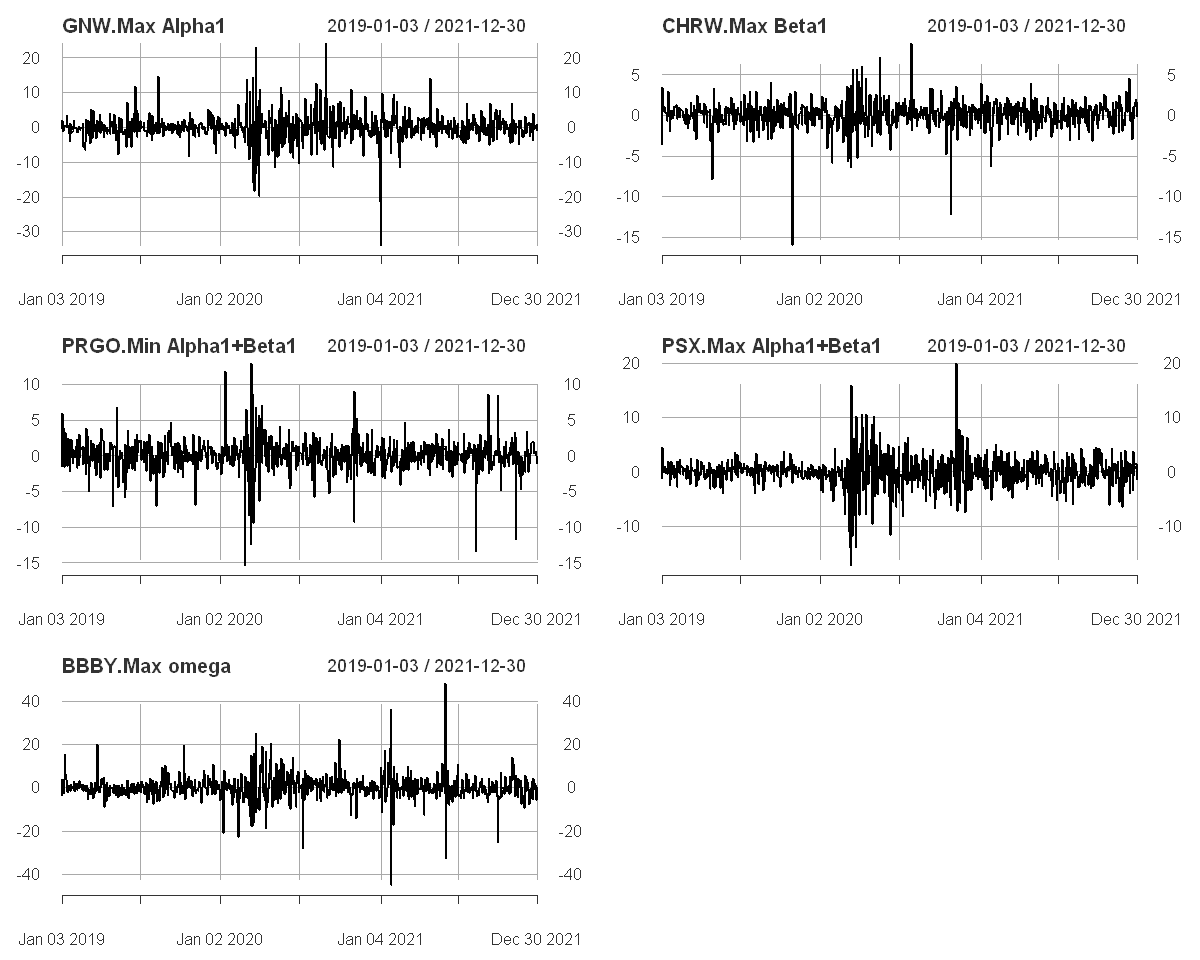

In [325]:
options(repr.plot.width = 10, repr.plot.height = 8)
par(mfrow = c(3, 2))

plot(lrets$GNW,  main = "GNW.Max Alpha1")
plot(lrets$CHRW,  main = "CHRW.Max Beta1")
plot(lrets$PRGO,  main = "PRGO.Min Alpha1+Beta1")
plot(lrets$PSX,  main = "PSX.Max Alpha1+Beta1")
plot(lrets$BBBY,  main = "BBBY.Max omega")

**Comments:  
From the chart, Stock4 PSX which has <span style='background:yellow'>Maximum $\alpha_1+\beta_1$</span> shows volatility spike persistence much longer, as well as slow decay, and also shows volatility clustering.** 

#####  <span style='background: lightblue'>5. Use the GARCH volatility of the cross-section of 100 stocks for every day to obtain median "market" volatility and its quantiles (95% and 5%). Create a figure plotting the cross-section of median, the 95% quantile, and the 5% quantile "market" volatility that you have obtained. Please, comment.</span>

* Observe stock volatility by chart

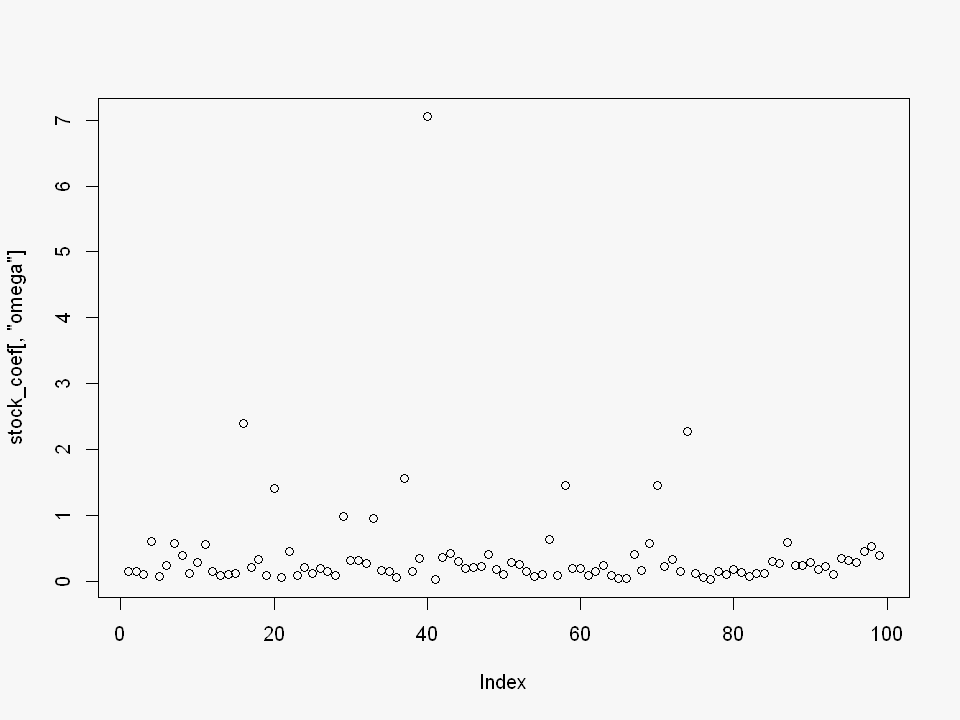

In [333]:
par(bg = "#f7f7f7")
options(repr.plot.width = 8, repr.plot.height = 6)
plot(stock_coef[,"omega"])

* Use GARCH result to calculate cross-section "market" volatility 

In [319]:
median_vol <- median(stock_coef[,"omega"])
median_vol
quantile(stock_coef[,"omega"],c(0.05, 0.95))

[1] 0.207364

5%      95% 
0.058340 1.456723

**Coments:  
Our median "market" volatility is 0.207, 5% quantiles at 0.058, 95% quantiles at 1.456.**

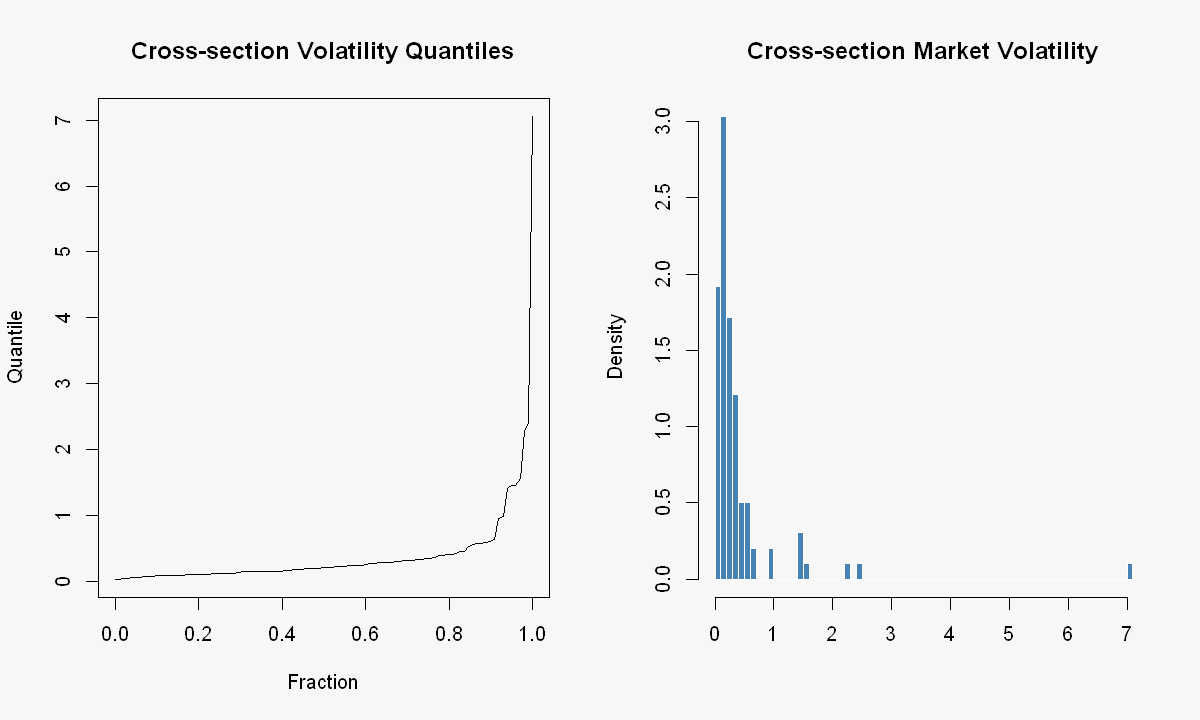

In [337]:
par(bg = "#f7f7f7")
options(repr.plot.width = 10, repr.plot.height = 6)
par(mfrow = c(1, 2))
plot((1:N - 1)/(N - 1), sort(stock_coef[,"omega"]), type="l",
     main = "Cross-section Volatility Quantiles", xlab = "Fraction", ylab = "Quantile")

hist(stock_coef[,"omega"], n = 100, probability = TRUE, border = "white",
     col = "steelblue", xlab = NA, main = "Cross-section Market Volatility")

**Comments:  
By formula defination $$\sigma_t^2 = \omega + \alpha_1 a_{t - 1}^2 + \beta_1 \sigma_{t - 1}^2$$ 
we could see $\omega$ is the long-term volatility. From our observation of Cross-section volatility from GARCH model results, 95% of stocks has $\omega$ lower than 1.5.**